In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1: Install Dependencies

In [ ]:
pip install torch transformers datasets scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Step 2: Import Dependencies and Set Device

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Set device: if CUDA is available, use GPU; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Step 3: Load and Explore the Data

In [ ]:
import pandas as pd
train_df = pd.read_excel('/content/drive/MyDrive/INFO 617/INFO 617 Group Project Train Val.xlsx')
test_df  = pd.read_excel('/content/drive/MyDrive/INFO 617/INFO 617_Group Project Test Set.xlsx')

# Check for any missing values
print(train_df.isnull().sum())

# Show basic statistics
print(train_df.head())


Sentence    0
Label       0
dtype: int64
                                            Sentence      Label
0                                             Hello,      GREET
1   the rubella virus IgM was detected at around ...     REPEAT
2  which has a 50% chance of causing intrauterine...  DIAGNOISE
3  Intrauterine infection can lead to risks such ...    EXPLAIN
4  Please note that these risks may or may not oc...    EXPLAIN


Basic Text Cleaning

In [ ]:
import re

# Function to clean the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove punctuation and non-alphanumeric characters
    return text

# Apply text cleaning
train_df['cleaned_sentence'] = train_df['Sentence'].apply(clean_text)
test_df['cleaned_sentence'] = test_df['Sentence'].apply(clean_text)

# Display a sample of the cleaned data
print(train_df[['Sentence', 'cleaned_sentence']].head())


                                            Sentence  \
0                                             Hello,   
1   the rubella virus IgM was detected at around ...   
2  which has a 50% chance of causing intrauterine...   
3  Intrauterine infection can lead to risks such ...   
4  Please note that these risks may or may not oc...   

                                    cleaned_sentence  
0                                              hello  
1   the rubella virus igm was detected at around ...  
2  which has a 50 chance of causing intrauterine ...  
3  intrauterine infection can lead to risks such ...  
4  please note that these risks may or may not oc...  


Code for Checking Class Imbalance and Calculating Class Weights:

In [ ]:
# Label encoding: Map labels to integers
label_mapping = {label: idx for idx, label in enumerate(train_df['Label'].unique())}

# Ensure that 'label_id' column is created properly
train_df['label_id'] = train_df['Label'].map(label_mapping)
test_df['label_id'] = test_df['Label'].map(label_mapping)

# Verify that 'label_id' has been added
print(train_df[['Label', 'label_id']].head())  # Check the 'label_id' column in train_df
print(test_df[['Label', 'label_id']].head())  # Check the 'label_id' column in test_df


       Label  label_id
0      GREET         0
1     REPEAT         1
2  DIAGNOISE         2
3    EXPLAIN         3
4    EXPLAIN         3
       Label  label_id
0  DIAGNOISE         2
1      TREAT         4
2      TREAT         4
3    EXPLAIN         3
4      TREAT         4


<ipython-input-10-3ebb4f741c8a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='Set2')


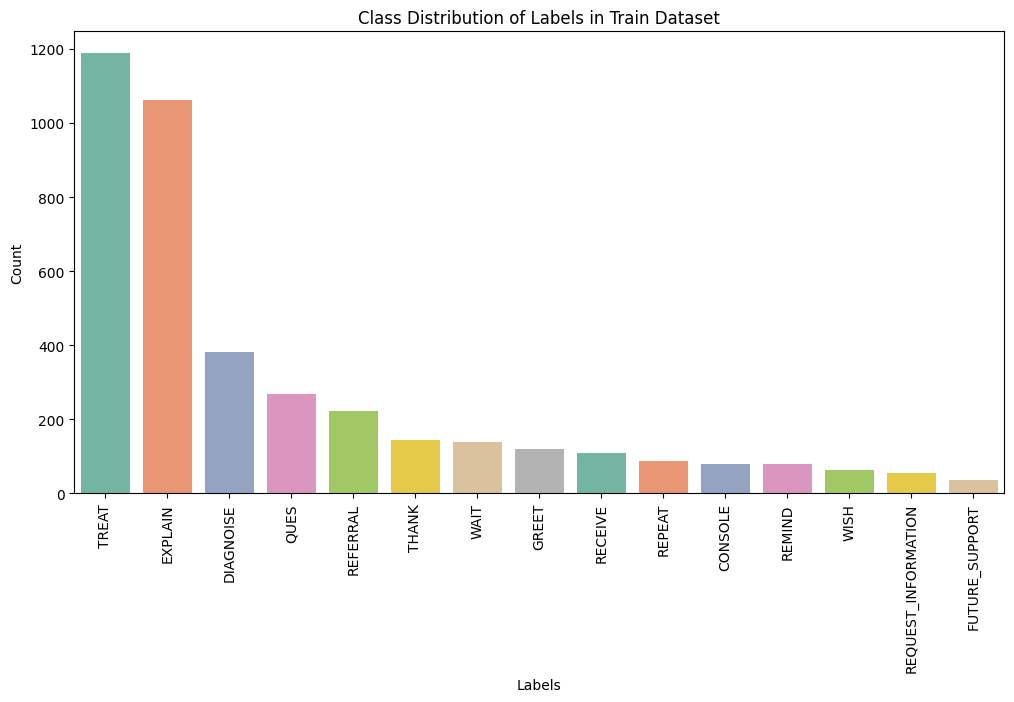

Class Distribution:
Label
TREAT                  1188
EXPLAIN                1061
DIAGNOISE               381
QUES                    267
REFERRAL                222
THANK                   145
WAIT                    139
GREET                   120
RECEIVE                 110
REPEAT                   86
CONSOLE                  78
REMIND                   78
WISH                     64
REQUEST_INFORMATION      55
FUTURE_SUPPORT           36
Name: count, dtype: int64
Class Weights: tensor([2.2389, 3.1240, 0.7052, 0.2532, 0.2262, 1.2102, 2.4424, 4.8848, 1.0062,
        4.1979, 1.8529, 1.9329, 3.4444, 3.4444, 7.4630], device='cuda:0')


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# Check the class distribution in the train dataset
class_distribution = train_df['Label'].value_counts()

# Plotting the class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='Set2')
plt.title('Class Distribution of Labels in Train Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Show the class distribution as text output
print("Class Distribution:")
print(class_distribution)

import numpy as np  # Import NumPy

# Calculate class weights based on the frequency of each label
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_id'].values),
    y=train_df['label_id'].values
)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Display the class weights
print("Class Weights:", class_weights_tensor)



Train-Validation Split (90%-10%)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the train_df into train (90%) and validation (10%)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Verify the split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


Training set size: 3627
Validation set size: 403


Tokenization and Padding

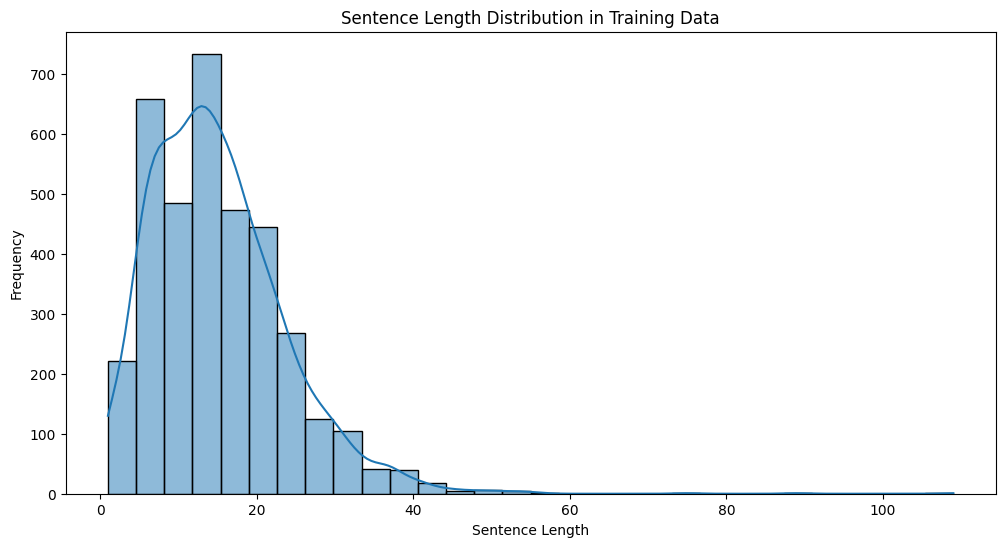

Maximum sentence length in training data: 109


In [ ]:
# Check the length of each sentence in the train dataset
train_df['sentence_length'] = train_df['cleaned_sentence'].apply(lambda x: len(x.split()))

# Plot the distribution of sentence lengths
plt.figure(figsize=(12, 6))
sns.histplot(train_df['sentence_length'], bins=30, kde=True)
plt.title('Sentence Length Distribution in Training Data')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

# Check the maximum sentence length
max_length = train_df['sentence_length'].max()
print(f"Maximum sentence length in training data: {max_length}")


In [ ]:
from transformers import BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode sentences
def tokenize_and_encode(sentences, tokenizer, max_length=128):
    return tokenizer.batch_encode_plus(
        sentences,
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length=max_length,  # Maximum length of the sentence
        padding='max_length',  # Pad sentences to max_length
        truncation=True,  # Truncate sentences longer than max_length
        return_attention_mask=True,
        return_tensors='pt',  # Return PyTorch tensors
    )

# Apply tokenization to train, validation, and test datasets
train_encodings = tokenize_and_encode(train_df['cleaned_sentence'].to_list(), tokenizer)
val_encodings = tokenize_and_encode(val_df['cleaned_sentence'].to_list(), tokenizer)
test_encodings = tokenize_and_encode(test_df['cleaned_sentence'].to_list(), tokenizer)

# Display a sample from the tokenized data (first input_ids)
print(train_encodings['input_ids'][0])  # Check tokenized sentence for the first instance


tensor([  101,  4067,  2017,  2005,  2115, 11752,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

Dataset Creation and DataLoader Setup

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

# Custom Dataset class for handling tokenized data
class MedicalDataset(Dataset):
    def __init__(self, encodings, labels, tokenizer):
        self.encodings = encodings
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Directly return the tensors from the encoding dictionary
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Labels are still a tensor
        return item

# Convert labels to integer IDs (if not already done)
train_labels = train_df['label_id'].to_list()
val_labels = val_df['label_id'].to_list()
test_labels = test_df['label_id'].to_list()

# Create Dataset objects for train, validation, and test
train_dataset = MedicalDataset(train_encodings, train_labels, tokenizer)
val_dataset = MedicalDataset(val_encodings, val_labels, tokenizer)
test_dataset = MedicalDataset(test_encodings, test_labels, tokenizer)

# Create DataLoader objects for train, validation, and test
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Display a sample batch to verify DataLoader output
sample_batch = next(iter(train_dataloader))
print(sample_batch.keys())  # Should include 'input_ids', 'attention_mask', 'labels'


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


Code for Loss Function, Model Setup, and Optimizer:

In [ ]:
from torch.nn import CrossEntropyLoss  # Add this import
from torch.optim import AdamW
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
import torch

# Step 6: Loss Function with Class Weights
loss_fn = CrossEntropyLoss(weight=class_weights_tensor)  # Using class weights

# Step 7: Model Setup (Load Pre-trained BERT Model)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_mapping)  # Number of labels (classes) in your dataset
)

# Move model to the device (GPU/CPU)
model.to(device)

# Step 8: Optimizer Setup (AdamW and Learning Rate Scheduler)
optimizer = AdamW(model.parameters(), lr=2e-5)  # Learning rate for fine-tuning BERT

# Total number of training steps (for learning rate scheduling)
total_steps = len(train_dataloader) * 3  # 3 epochs for training

# Scheduler to adjust learning rate during training (Linear warm-up)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # No warmup steps
    num_training_steps=total_steps
)

# Display the model architecture (optional)
print(model)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Training Loop:

In [ ]:
import pandas as pd

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

epochs = 10  # Number of epochs for training

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Training loop
    for batch in train_dataloader:
        # Get data and move to the device (GPU/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()
        optimizer.step()  # Update model parameters
        scheduler.step()  # Update learning rate

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(logits, dim=1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_preds / total_preds

    # Validation loop after each epoch
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():  # No gradients during evaluation
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            val_loss += loss.item()
            _, predicted = torch.max(logits, dim=1)
            val_correct_preds += (predicted == labels).sum().item()
            val_total_preds += labels.size(0)

    # Calculate validation loss and accuracy
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_accuracy = val_correct_preds / val_total_preds

    # Store the results in the DataFrame using pd.concat
    epoch_results = pd.DataFrame([{
        "Epoch": epoch + 1,
        "Train Loss": epoch_loss,
        "Train Accuracy": epoch_accuracy,
        "Validation Loss": val_epoch_loss,
        "Validation Accuracy": val_epoch_accuracy
    }])

    # Concatenate the results
    results = pd.concat([results, epoch_results], ignore_index=True)

    # Print the results for the current epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.4f}")
    print(f"Validation Loss: {val_epoch_loss:.4f} | Validation Accuracy: {val_epoch_accuracy:.4f}")
    print("-" * 50)

# Print the final results table
print("\nFinal Training and Validation Results:")
print(results)


<ipython-input-23-fe6972c02e13>:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, epoch_results], ignore_index=True)


Epoch 1/10
Train Loss: 0.5067 | Train Accuracy: 0.8831
Validation Loss: 0.6306 | Validation Accuracy: 0.7916
--------------------------------------------------
Epoch 2/10
Train Loss: 0.5066 | Train Accuracy: 0.8837
Validation Loss: 0.3911 | Validation Accuracy: 0.7916
--------------------------------------------------
Epoch 3/10
Train Loss: 0.5080 | Train Accuracy: 0.8803
Validation Loss: 0.4461 | Validation Accuracy: 0.7916
--------------------------------------------------
Epoch 4/10
Train Loss: 0.5104 | Train Accuracy: 0.8831
Validation Loss: 0.2000 | Validation Accuracy: 0.7916
--------------------------------------------------
Epoch 5/10
Train Loss: 0.5078 | Train Accuracy: 0.8859
Validation Loss: 0.4828 | Validation Accuracy: 0.7916
--------------------------------------------------
Epoch 6/10
Train Loss: 0.5096 | Train Accuracy: 0.8825
Validation Loss: 0.5758 | Validation Accuracy: 0.7916
--------------------------------------------------
Epoch 7/10
Train Loss: 0.5076 | Train Ac

Evaluation on Test Dataset

In [ ]:
# Check the first few rows of the test dataframe
print(test_df.head())


                                            Sentence      Label  \
0  I have calculated it for you, and your BMI is ...  DIAGNOISE   
1  In this case, you need to eat more carbohydrat...      TREAT   
2  Normally, you should consume 6-8 liang of stap...      TREAT   
3  With this, your weight should increase by 8 li...    EXPLAIN   
4  When dining outside or buying takeaway, you sh...      TREAT   

                                    cleaned_sentence  label_id  
0  i have calculated it for you and your bmi is n...         2  
1  in this case you need to eat more carbohydrate...         4  
2  normally you should consume 68 liang of staple...         4  
3  with this your weight should increase by 8 lia...         3  
4  when dining outside or buying takeaway you sho...         4  


Test Loss: 0.7209 | Test Accuracy: 0.8045

Classification Report:
                     precision    recall  f1-score   support

              GREET       1.00      1.00      1.00        29
             REPEAT       0.00      0.00      0.00        30
          DIAGNOISE       0.64      0.80      0.71       119
            EXPLAIN       0.82      0.72      0.76       316
              TREAT       0.76      0.91      0.83       281
           REFERRAL       0.75      0.91      0.82        74
            RECEIVE       0.97      0.92      0.94        37
REQUEST_INFORMATION       0.67      0.20      0.31        20
               QUES       0.98      0.95      0.97       109
               WISH       1.00      0.71      0.83        21
              THANK       0.84      0.98      0.90        43
               WAIT       0.85      0.88      0.87        52
            CONSOLE       1.00      0.70      0.83        27
             REMIND       0.74      0.81      0.77        21
     FUTURE_SUPPOR

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


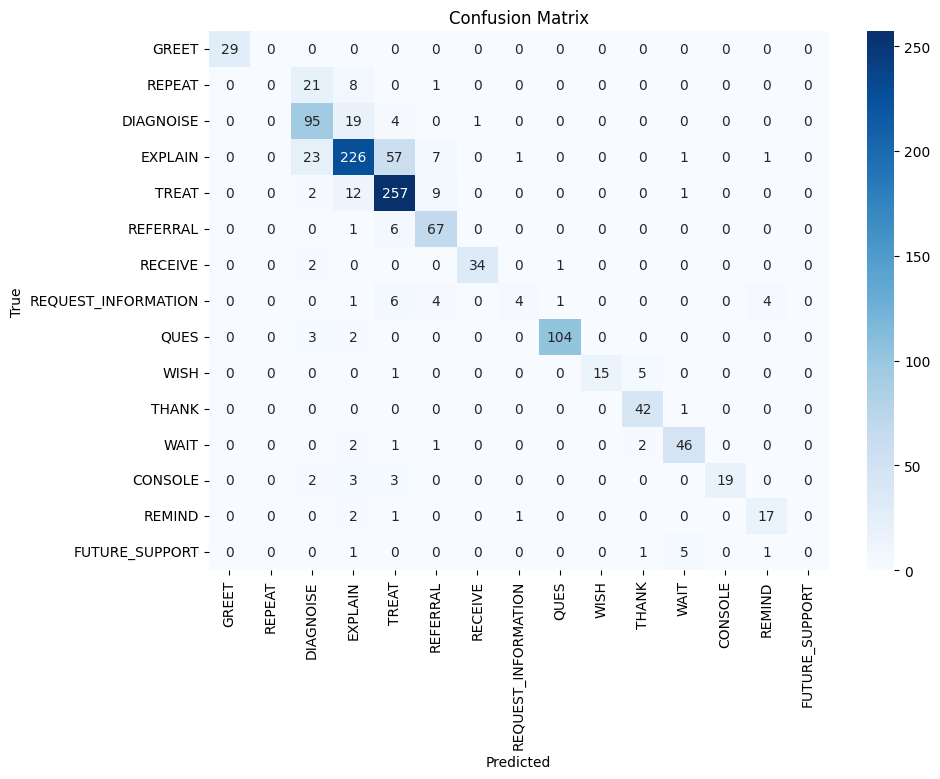

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 10: Test the Model on Test Data
model.eval()  # Set model to evaluation mode
test_loss = 0.0
test_correct_preds = 0
test_total_preds = 0
test_labels_list = []
test_preds_list = []

# No gradients during evaluation
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        loss = outputs.loss
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(logits, dim=1)
        test_correct_preds += (predicted == labels).sum().item()
        test_total_preds += labels.size(0)

        # Collect labels and predictions for classification report
        test_labels_list.extend(labels.cpu().numpy())
        test_preds_list.extend(predicted.cpu().numpy())

# Calculate test loss and accuracy
test_epoch_loss = test_loss / len(test_dataloader)
test_epoch_accuracy = test_correct_preds / test_total_preds

# Display the results
print(f"Test Loss: {test_epoch_loss:.4f} | Test Accuracy: {test_epoch_accuracy:.4f}")

# Step 10.1: Generate Classification Report
print("\nClassification Report:")
print(classification_report(test_labels_list, test_preds_list, target_names=list(label_mapping.keys())))

# Step 10.2: Confusion Matrix
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
